In [2]:
'''
U-Net Architecture
+-------------+-----------------+-------------------------------+------------------+
| Layer       | Type            | Configuration                 | Output Size      |
+-------------+-----------------+-------------------------------+------------------+
| Input       | Image           | 572 x 572 x 1 (Grayscale)     | 572 x 572 x 1    |
|             |                 |                               |                  |
| ========== ENCODER (CONTRACTING PATH) ==========                                 |
|             |                 |                               |                  |
| Conv1-1     | Convolution     | 64 filters (3x3), No padding  | 570 x 570 x 64   |
| Conv1-2     | Convolution     | 64 filters (3x3), No padding  | 568 x 568 x 64   |
| Pool1       | Max Pooling     | 2x2 window, Stride 2          | 284 x 284 x 64   |
|             |                 |                               |                  |
| Conv2-1     | Convolution     | 128 filters (3x3), No padding | 282 x 282 x 128  |
| Conv2-2     | Convolution     | 128 filters (3x3), No padding | 280 x 280 x 128  |
| Pool2       | Max Pooling     | 2x2 window, Stride 2          | 140 x 140 x 128  |
|             |                 |                               |                  |
| Conv3-1     | Convolution     | 256 filters (3x3), No padding | 138 x 138 x 256  |
| Conv3-2     | Convolution     | 256 filters (3x3), No padding | 136 x 136 x 256  |
| Pool3       | Max Pooling     | 2x2 window, Stride 2          | 68 x 68 x 256    |
|             |                 |                               |                  |
| Conv4-1     | Convolution     | 512 filters (3x3), No padding | 66 x 66 x 512    |
| Conv4-2     | Convolution     | 512 filters (3x3), No padding | 64 x 64 x 512    |
| Pool4       | Max Pooling     | 2x2 window, Stride 2          | 32 x 32 x 512    |
|             |                 |                               |                  |
| ========== BOTTLENECK ==========                                                 |
|             |                 |                               |                  |
| Conv5-1     | Convolution     | 1024 filters (3x3), No padding| 30 x 30 x 1024   |
| Conv5-2     | Convolution     | 1024 filters (3x3), No padding| 28 x 28 x 1024   |
|             |                 |                               |                  |
| ========== DECODER (EXPANDING PATH) ==========                                   |
|             |                 |                               |                  |
| UpConv4     | Up-Convolution  | 512 filters (2x2), Stride 2   | 56 x 56 x 512    |
| Crop4       | Crop & Concat   | From Conv4-2 (64x64 → 56x56)  | 56 x 56 x 1024   |
| Conv6-1     | Convolution     | 512 filters (3x3), No padding | 54 x 54 x 512    |
| Conv6-2     | Convolution     | 512 filters (3x3), No padding | 52 x 52 x 512    |
|             |                 |                               |                  |
| UpConv3     | Up-Convolution  | 256 filters (2x2), Stride 2   | 104 x 104 x 256  |
| Crop3       | Crop & Concat   | From Conv3-2 (136x136→104x104)| 104 x 104 x 512  |
| Conv7-1     | Convolution     | 256 filters (3x3), No padding | 102 x 102 x 256  |
| Conv7-2     | Convolution     | 256 filters (3x3), No padding | 100 x 100 x 256  |
|             |                 |                               |                  |
| UpConv2     | Up-Convolution  | 128 filters (2x2), Stride 2   | 200 x 200 x 128  |
| Crop2       | Crop & Concat   | From Conv2-2 (280x280→200x200)| 200 x 200 x 256  |
| Conv8-1     | Convolution     | 128 filters (3x3), No padding | 198 x 198 x 128  |
| Conv8-2     | Convolution     | 128 filters (3x3), No padding | 196 x 196 x 128  |
|             |                 |                               |                  |
| UpConv1     | Up-Convolution  | 64 filters (2x2), Stride 2    | 392 x 392 x 64   |
| Crop1       | Crop & Concat   | From Conv1-2 (568x568→392x392)| 392 x 392 x 128  |
| Conv9-1     | Convolution     | 64 filters (3x3), No padding  | 390 x 390 x 64   |
| Conv9-2     | Convolution     | 64 filters (3x3), No padding  | 388 x 388 x 64   |
|             |                 |                               |                  |
| Output      | Convolution     | 2 filters (1x1) + Softmax     | 388 x 388 x 2    |
+-------------+-----------------+-------------------------------+------------------+

Key Characteristics of U-Net:

- **Symmetric U-Shape**: Encoder (contracting) path followed by decoder (expanding) path
- **Skip Connections**: Feature maps from encoder are concatenated with decoder maps
  (helps recover spatial information lost during downsampling)
- **No Padding**: Original paper uses unpadded convolutions (valid padding)
  causing output to be smaller than input (388x388 vs 572x572)
- **No Fully Connected Layers**: Fully convolutional architecture enables 
  arbitrary input sizes
- **ReLU Activation**: Applied after every convolution layer
- **Dropout**: Optional, typically 0.5 after convolutional layers in deeper networks
- **Total Parameters**: ~31 million (original U-Net)

Architecture Philosophy:

1. **Contracting Path** (Left side of U):
   - Captures context through repeated convolution and max pooling
   - Progressively reduces spatial dimensions while increasing feature channels
   - Standard convolutional network architecture

2. **Bottleneck** (Bottom of U):
   - Smallest spatial dimensions, highest number of feature channels
   - Captures the most abstract features

3. **Expanding Path** (Right side of U):
   - Recovers spatial resolution through up-convolutions (transposed convolutions)
   - Skip connections from encoder provide fine-grained spatial information
   - Enables precise localization for segmentation

4. **Skip Connections**:
   - Concatenate encoder features with corresponding decoder features
   - Encoder features are cropped to match decoder size (due to no padding)
   - Combines high-resolution encoder features with upsampled decoder features
   - Critical for accurate pixel-wise segmentation

Advantages:
- Works well with very few training images (data augmentation helps)
- Achieves precise localization with skip connections
- End-to-end training for image-to-image tasks
- Fast inference (fully convolutional, no dense layers)

Common Use Cases:
- Medical image segmentation (original purpose)
- Satellite image analysis
- Any pixel-wise prediction task requiring spatial precision
'''
print()

In [26]:
#########################
## Importing libraries ##
#########################

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# cuda

cuda


In [27]:
###################
## UNet building ##
###################

#-------
## Define DoubleConv
#-------

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # bias=False for BatchNorm2d()
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)            
        )

    def forward(self, X):
        return self.cnn(X)

#-------
## Building
#-------

import torchvision.transforms.functional as TF

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]): # In this example, we just do binary segmentation, so can set out_channels=1
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature # set in_channels for shape matching of the next layer

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # ConvTranpose: https://www.youtube.com/watch?v=qb4nRoEAASA
            self.ups.append(DoubleConv(feature*2, feature))                                  # This ConvTranspose is for upsampling back 64->128->256->512

        # Bottleneck part (transition from down to up)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final conv layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, X):
        skip_connections = [] # Store values from down block to use later on

        for down in self.downs:
            X = down(X)
            skip_connections.append(X)
            X = self.pool(X)

        X = self.bottleneck(X)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2): # So idx takes values: 0, 2, 4, 6 (accessing only the ConvTranspose layers for upsampling)
            X = self.ups[idx](X)
            skip_connection = skip_connections[idx//2]

            if X.shape != skip_connection.shape:
                X = TF.resize(X, skip_connection.shape[2:]) # ensure X and skip_connection have the same shape for torch.cat()
            
            concat_skip = torch.cat((skip_connection, X), dim=1) # Combining high-resolution encoder features with upsampled decoder features.
            X = self.ups[idx+1](concat_skip)

        return self.final_conv(X)

In [1]:
#####################
## Dataset prepare ##
#####################

from datasets import load_dataset

teeth_xray = load_dataset(path="SerdarHelli/SegmentationOfTeethPanoramicXRayImages", split='train')

print(teeth_xray)
# Dataset({
#     features: ['image', 'label'],
#     num_rows: 116
# })

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

data/train-00000-of-00001-f8e051e737d32f(…):   0%|          | 0.00/26.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 116
})


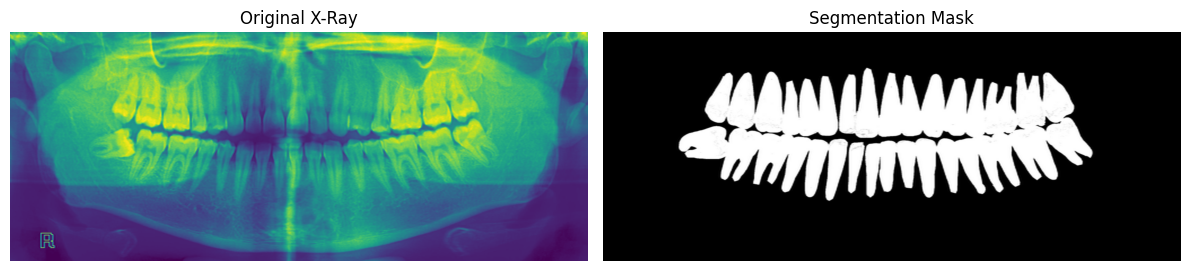

In [32]:
#---------
## Show an example
#---------

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(teeth_xray[0]['image'])
axes[0].set_title("Original X-Ray")
axes[0].axis('off')  # Removes the x and y axis numbers

# Plot the mask
# We use cmap='gray' because segmentation masks are often single-channel
axes[1].imshow(teeth_xray[0]['label'], cmap='gray')
axes[1].set_title("Segmentation Mask")
axes[1].axis('off')

# Adjust layout to ensure titles don't overlap with images
plt.tight_layout()
plt.show()

In [54]:
#########################
## Image Preprocessing ##
#########################

IMG_SIZE = (120, 300)

#--------
## Initial preprocessing
#--------

preprocess = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
    ]
)

inputs_temp = []

for record in tqdm(iterable=teeth_xray, desc="Preprocessing Images"):
    image = record['image']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocessing
    input_tensor = preprocess(image)
    
    # append to inputs_temp
    inputs_temp.append(input_tensor)
    
#----
## Calculate mean and std after inital preprocessing
#----

import numpy as np

np.random.seed(0)
idx = np.random.randint(0, len(inputs_temp), int(len(inputs_temp)*0.8))

image_placeholder = torch.concat([inputs_temp[i] for i in idx], axis=1)
print(image_placeholder.shape)
# torch.Size([3, 11040, 300])

mean_image = torch.mean(image_placeholder, dim=(1, 2))
std_image = torch.std(image_placeholder, dim=(1, 2))
print(mean_image) # tensor([0.4016, 0.4016, 0.4016])
print(std_image)  # tensor([0.2095, 0.2095, 0.2095])

#----
## Re-normalize with calculated mean and std
#----
'''Here we don't re-normalize the mask (label), just convert it to tensor using transforms.ToTensor()'''

preprocess_image = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_image, std=std_image)
    ]
)

inputs_final = []

for record in tqdm(iterable=teeth_xray, desc="Preprocessing Images"):
    image = record['image']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")

    # The mask (or label) should be in grayscale
    label = label.convert("L")
        
    # preprocessing
    input_tensor = preprocess_image(image)
    label_tensor = preprocess(label)
    
    # append to inputs_temp
    inputs_final.append([input_tensor, label_tensor])

del inputs_temp

Preprocessing Images:   0%|          | 0/116 [00:00<?, ?it/s]

torch.Size([3, 11040, 300])
tensor([0.4016, 0.4016, 0.4016])
tensor([0.2095, 0.2095, 0.2095])


Preprocessing Images:   0%|          | 0/116 [00:00<?, ?it/s]

In [70]:
#######################
## Dataset splitting ##
#######################

#-----
## Train - Val - Test split
#-----

train_len = int(0.8 * len(inputs_final)) # MUST be INTEGER
val_len = int(0.1 * len(inputs_final))
test_len = len(inputs_final) - (train_len + val_len)

print(train_len, val_len, test_len)
# 92 11 13

from torch.utils.data import DataLoader, TensorDataset, random_split

train_split, val_split, test_split = random_split(dataset=inputs_final, lengths=[train_len, val_len, test_len])

#-----
## Train - Val - Test loader
#-----

BATCH_SIZE = 8

train_set = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True) # shuffle=True to reshuffle the data after every epoch
val_set = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False)
test_set = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)

92 11 13


In [56]:
##########################
## model initialization ##
##########################

torch.manual_seed(42)
model = UNet().to(device)

##################################
## Loss - Optimizer - Scheduler ##
##################################

loss_fn = nn.BCEWithLogitsLoss() # If you have multiple types of masks, use CrossEntropyLoss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10, factor=0.25)

In [57]:
################################
## Training - Validating loop ##
################################

epochs = 100

train_loss_list, val_loss_list = [], []

for epoch in tqdm(iterable=range(1, epochs+1), desc="Training"):
    # --- TRAINING ---
    _ = model.train() # Turn on training mode, enable gradient tracking
    train_loss = 0
    for _, (images, labels) in enumerate(train_set):
        # moves values to device
        images = images.to(device)
        labels = labels.to(device)
        
        # (Standard training steps: forward, loss, zero_grad, backward, step)
        preds = model(images)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_set)
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval() # 1. Set model to evaluation mode
    val_loss = 0
    total = 0
    with torch.inference_mode(): # 2. Turn off gradient tracking to save memory      
        for _, (images, labels) in enumerate(val_set): # 3. Iterate through val_set
            # moves values to device
            images = images.to(device)
            labels = labels.to(device)

            val_preds = model(images)
            
            # Accumulate loss to get an average for the whole set
            val_loss += loss_fn(val_preds, labels).item()
            
    avg_val_loss = val_loss / len(val_set)
    
    train_loss_list.append(loss.item())
    val_loss_list.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step(avg_val_loss)
    
    if (epoch % 20 == 0) or (epoch == 1):
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Train loss: {avg_train_loss:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Current LR: {current_lr}")

Training:   0%|          | 0/100 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1
Train loss: 0.4666
Validation loss: 0.4722
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20
Train loss: 0.0923
Validation loss: 0.1001
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 40
Train loss: 0.0715
Validation loss: 0.0887
Current LR: 0.001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 60
Train loss: 0.0584
Validation loss: 0.0924
Current LR: 0.00025
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 80
Train loss: 0.0565
Validation loss: 0.0945
Current LR: 1.5625e-05
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 100
Train loss: 0.0555
Validation loss: 0.0954
Current LR: 9.765625e-07


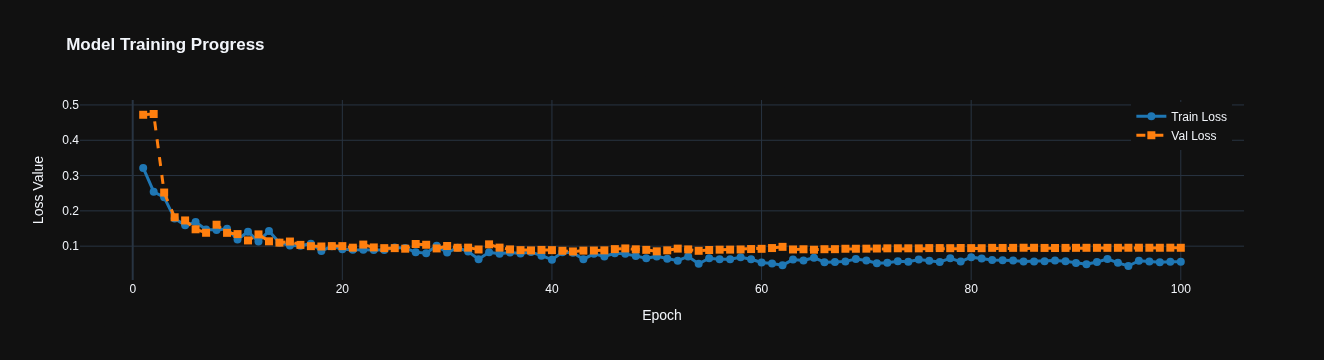

In [58]:
#######################################
## Drawing Train and Val loss curves ##
#######################################

def plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list):
    import plotly.graph_objects as pgo
    import numpy as np
    
    # 1. Define the X-axis (epochs)
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # 2. Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # 3. Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    # 4. Layout & Styling
    fig.update_layout(
        title='<b>Model Training Progress</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark', # Clean dark background
        hovermode='x unified',   # Shows both values on hover
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()
    
plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list)

In [89]:
#############
## Testing ##
#############

_ = model.eval()

preds_list = []
with torch.inference_mode():
    test_loss = 0
    for _, (images, labels) in enumerate(test_set):
        # moves values to device
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        preds_list.append(preds)

        loss = loss_fn(preds, labels)        
        test_loss += loss.item()
        
    avg_test_loss = test_loss / len(test_set)

print(f'Average test lost: {avg_test_loss}')
# Average test lost: 0.10302801802754402

Average test lost: 0.07439084351062775


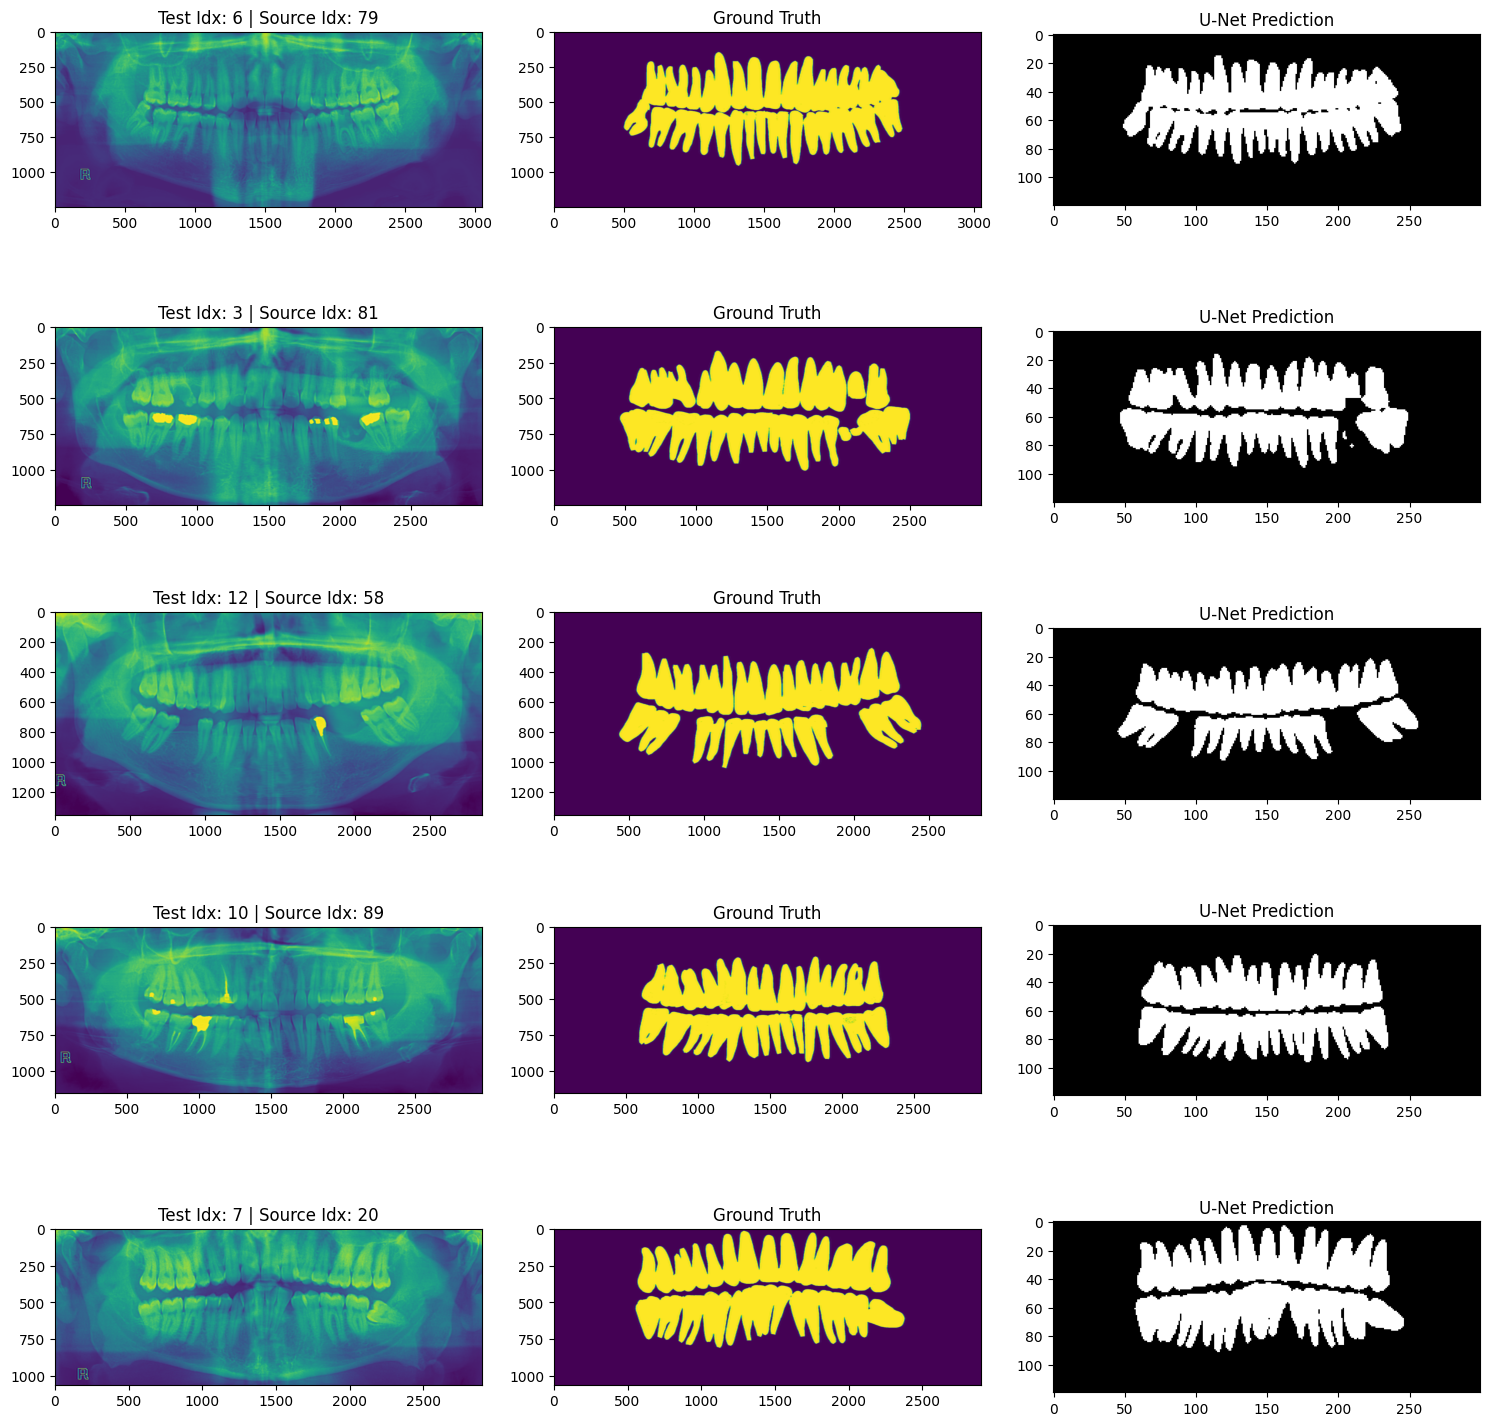

In [102]:
################################
## Visualize some predictions ##
################################

num_samples_to_show = 5

preds_tensor = torch.cat(preds_list, dim=0)

# 1. Generate random indices for the test subset
np.random.seed(42)
idx_random = np.random.randint(0, test_len, num_samples_to_show )

# 2. Map those back to the source dataset indices
# This ensures we pull the raw PIL images from teeth_xray
idx_original = [test_split.indices[i] for i in idx_random]

# 3. Create the plot with 3 columns
fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(15, 15))

for i, (r_idx, o_idx) in enumerate(zip(idx_random, idx_original)):
    
    # --- Source Data (No Preprocessing) ---
    raw_record = teeth_xray[o_idx]
    original_xray = raw_record['image']
    original_mask = raw_record['label']

    # --- Prediction Processing ---
    # We use the relative index (r_idx) to get the correct model output
    # Flattening batch dimension if necessary with .squeeze()
    logit_pred = preds_tensor[r_idx].squeeze()
    binary_pred = (logit_pred > 0).float().cpu().numpy()

    # --- Column 1: Original X-Ray (Raw) ---
    axes[i, 0].imshow(original_xray)
    axes[i, 0].set_title(f"Test Idx: {r_idx} | Source Idx: {o_idx}")
    
    # --- Column 2: Original Mask (Raw) ---
    axes[i, 1].imshow(original_mask)
    axes[i, 1].set_title("Ground Truth")
    
    # --- Column 3: Predicted Mask ---
    axes[i, 2].imshow(binary_pred, cmap='gray')
    axes[i, 2].set_title("U-Net Prediction")

plt.tight_layout()
plt.show()

In [ ]:
########################
## Saving whole model ##
########################

# import os
# os.chdir('../')
# os.getcwd() # '/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch'

from pathlib import Path

MODEL_PATH = Path("04_CNN").joinpath("save")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# PyTorch model can be saved in .pth or .pt format
PARAMS_NAME = "UNet_model.pth"

# Save the model (use model.state_dict() to save only the parameters)
torch.save(obj=model, f=MODEL_PATH.joinpath(PARAMS_NAME))